# Trabajo práctico N°1: FIUFIP

## Parte 1 - Análisis de datos
- Continanza, Nicolás (97576)
- De Angelis Riva, Lukas Nahuel  (103784)

#### FIUFIP: Que No Se Escape Nadie (?)

A partir de la información recolectada por FIUFIP, queremos hacer un análisis que nos permita inferir qué ciudadanos tienen un alto poder adquisitivo. Para esto, y tomando en cuenta la información con la que contamos y sus limitaciones, creemos que será valioso poder responder las siguientes preguntas, y evaluar si nos aportan información útil:

1. ¿Cuántas personas tienen un alto poder adquisitivo en los datos recolectados por la agencia?
2. ¿Hay alguna relación entre la edad de las personas encuestadas y su poder adquisitivo?
3. ¿Existe un cambio notable en la respuesta a la pregunta anterior si separamos la muestra por género?
4. Respondiendo las tres preguntas anteriores podríamos encontrar una relación entre las variables edad y género, y sería interesante saber qué tan similar o disímil es la variable edad entre los tipos de trabajo que realizan. Entonces, ¿Cómo se distribuye la edad de las personas encuestadas según su trabajo?
6. ¿Qué se puede decir sobre los tipos de sala más elegidos separando a los encuestados por edad?
7.
8.

## Bibliotecas

Comencemos por importar las bibliotecas a utilizar.

In [29]:
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib

import seaborn as sns
sns.set()

import squarify

import numpy as np

import functools
import operator

In [2]:
def get_data():
    GSPREADHSEET_DOWNLOAD_URL = (
        "https://docs.google.com/spreadsheets/d/{gid}/export?format=csv&id={gid}".format
    )
    TP_GID = '1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0'
    df = pd.read_csv(GSPREADHSEET_DOWNLOAD_URL(gid=TP_GID))
    return df    

In [3]:
df = get_data()

## Feature Engineering

Antes de comenzar el análisis exploratorio de los datos, estudiemos las características del dataset y analicemos si podemos hacer algunas mejoras para facilitar el trabajo.

### Missing Values

Comencemos por ver qué variables presentan valores nulos.

In [4]:
df.isna().apply(lambda c: functools.reduce(operator.or_, c))

anios_estudiados                              False
barrio                                         True
categoria_de_trabajo                           True
edad                                          False
educacion_alcanzada                           False
estado_marital                                False
ganancia_perdida_declarada_bolsa_argentina    False
genero                                        False
horas_trabajo_registradas                     False
religion                                      False
rol_familiar_registrado                       False
tiene_alto_valor_adquisitivo                  False
trabajo                                        True
dtype: bool

Vemos que los únicos missing values se dan en las columnas: `barrio`, `categoría_de_trabajo` y `trabajo`.

Analicemos ahora la cantidad de personas cuyo barrio desconocemos.

<AxesSubplot:ylabel='barrio'>

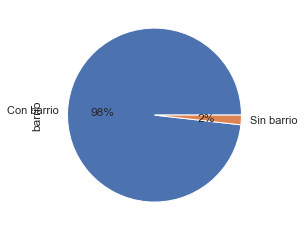

In [5]:
df['barrio'].notnull().apply(lambda x: 'Con barrio' if x else 'Sin barrio').value_counts().plot(
    kind='pie', autopct='%1.0f%%')

Se trata de un 2% del dataset, un valor que consideramos lo suficientemente grande como para no descartarlo.

Veamos si hay grandes diferencias de poder adquisitivo entre las personas que no indicaron su barrio y las que si.

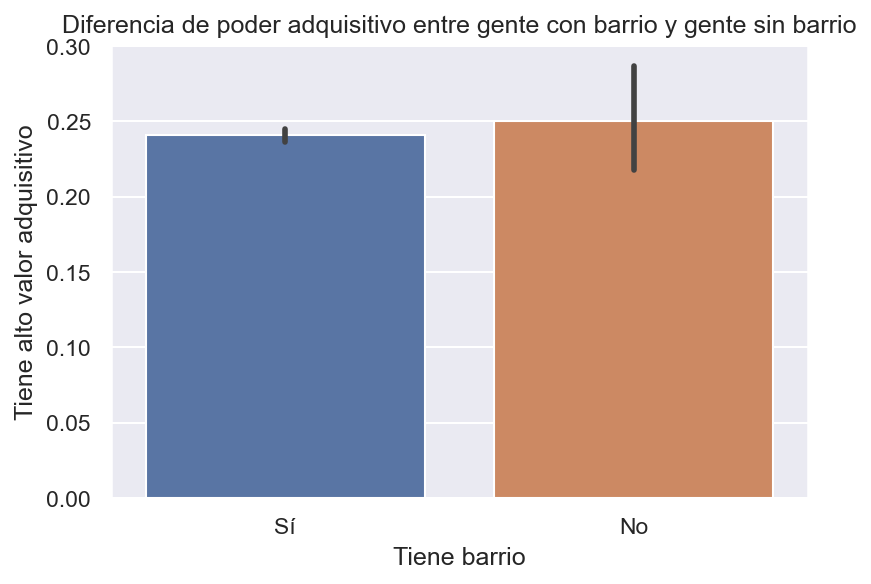

In [6]:
df_test_barrio = df[['barrio', 'tiene_alto_valor_adquisitivo']].copy()
df_test_barrio['tiene_barrio'] = df_test_barrio['barrio'].isna().apply(lambda x: 'No' if x else 'Sí')
del df_test_barrio['barrio']

plt.figure(dpi=150)
ax = sns.barplot(data=df_test_barrio, x='tiene_barrio', y='tiene_alto_valor_adquisitivo')

plt.ylabel("Tiene alto valor adquisitivo")
plt.xlabel("Tiene barrio")
plt.title('Diferencia de poder adquisitivo entre gente con barrio y gente sin barrio')
plt.show()

Vemos que, a priori, haber informado el barrio o no haberlo hecho no tiene un impacto significativo sobre la variable objetivo. Por lo tanto, rellenaremos esos valores faltantes asignando aleatoriamente un barrio, considerando la distribución de los mismos en la muestra que estamos analizando.

In [7]:
data_set_mejorado = df.copy()
barrios = df['barrio'].dropna()
cantidad = df['barrio'].isna().value_counts()[True]
muestra = barrios.sample(cantidad)
it = iter(muestra)
data_set_mejorado['barrio'] = data_set_mejorado['barrio'].apply(lambda x: next(it) if str(x) == 'nan' else x)

De forma similar, analizaremos la variable `categoria_de_trabajo`.

<AxesSubplot:ylabel='categoria_de_trabajo'>

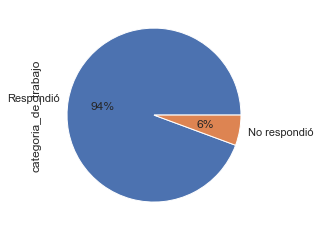

In [8]:
df['categoria_de_trabajo'].notnull().apply(lambda x: 'Respondió' if x else 'No respondió').value_counts().plot(
    kind='pie', autopct='%1.0f%%'
)

Nuevamente estamos frente a un caso donde no podemos despreciar aquellas muestras que no informen su categoría de trabajo.

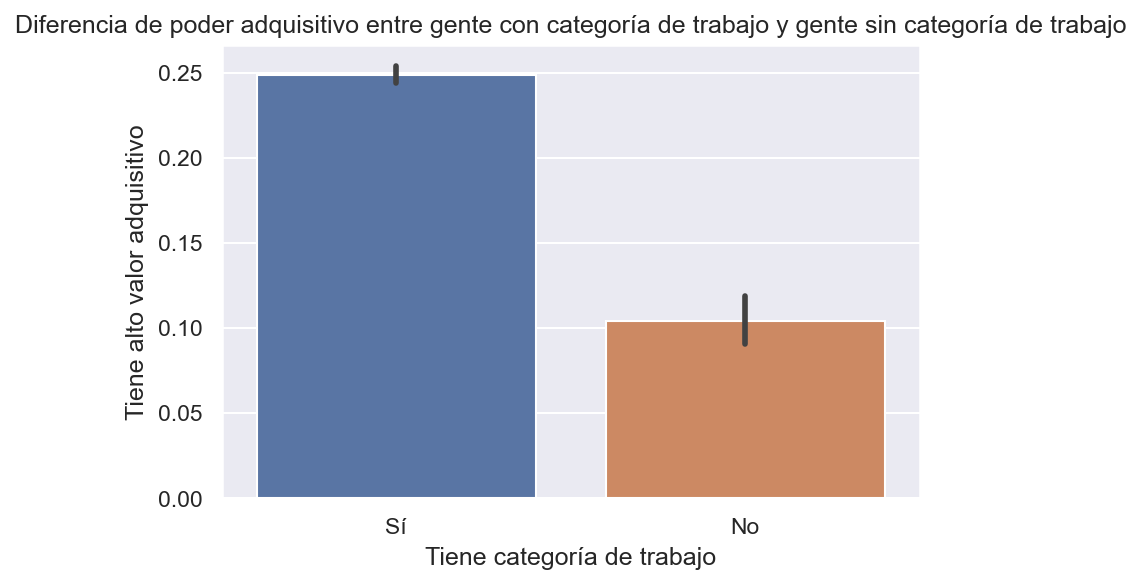

In [9]:
df_test_categoria = df[['categoria_de_trabajo', 'tiene_alto_valor_adquisitivo']].copy()
df_test_categoria['tiene_categoria'] = df_test_categoria['categoria_de_trabajo'].isna().apply(lambda x: 'No' if x else 'Sí')
del df_test_categoria['categoria_de_trabajo']

plt.figure(dpi=150)
ax = sns.barplot(data=df_test_categoria, x='tiene_categoria', y='tiene_alto_valor_adquisitivo')

plt.ylabel("Tiene alto valor adquisitivo")
plt.xlabel("Tiene categoría de trabajo")
plt.title('Diferencia de poder adquisitivo entre gente con categoría de trabajo y gente sin categoría de trabajo')
plt.show()

Aquí ya se puede ver información interesante: la gente que no responde su categoría de trabajo, en general tiene menor valor adquisitivo.

Veamos ahora la relación entre valores nulos en `trabajo` y valores nulos en `categoría_de_trabajo`.

In [10]:
df[['categoria_de_trabajo', 'trabajo']].isna().apply(lambda column: column.value_counts()[True])

categoria_de_trabajo    1836
trabajo                 1843
dtype: int64

Hay una diferencia de 7 entradas, que serán las siguientes:

In [11]:
df[df['categoria_de_trabajo'].notnull() & df['trabajo'].isna()]

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
5361,10,Palermo,sin_trabajo,18,1_anio,sin_matrimonio,0,hombre,40,cristianismo,con_hijos,0,NaN
10845,8,Palermo,sin_trabajo,23,7-8_grado,divorciado,0,hombre,35,cristianismo,sin_familia,0,NaN
14772,10,Palermo,sin_trabajo,17,1_anio,sin_matrimonio,0,hombre,30,cristianismo,con_hijos,0,NaN
20337,11,Palermo,sin_trabajo,18,2_anio,sin_matrimonio,0,mujer,10,cristianismo,con_hijos,0,NaN
23232,14,Palermo,sin_trabajo,20,5_anio,sin_matrimonio,0,hombre,40,judaismo,con_hijos,0,NaN
32304,13,Palermo,sin_trabajo,30,4_anio,matrimonio_civil,0,mujer,40,judaismo,casada,0,NaN
32314,14,Palermo,sin_trabajo,18,5_anio,sin_matrimonio,0,hombre,4,cristianismo,con_hijos,0,NaN


Esto quiere decir que tener un valor NA en `categoria_de_trabajo` se corresponde con tener un valor NA  en `trabajo`, y si hay un NA en trabajo, salvo por estos últimos 7 casos, habrá un NA en `categoria_de_trabajo`.

En base a esto, vamos a crear una nueva categoría llamada "sin_categoria", para todas aquellas personas que tengan valor nulo en `categoria_de_trabajo`, y otra llamada "no_responde" para quienes tengan valor nulo en `trabajo`.

In [12]:
data_set_mejorado['categoria_de_trabajo'] = data_set_mejorado['categoria_de_trabajo'].apply(lambda x: 'Sin categoria' if str(x) == 'nan' else x)

In [13]:
data_set_mejorado['trabajo'] = data_set_mejorado['trabajo'].apply(lambda x: 'No responde' if str(x) == 'nan' else x)

In [14]:
data_set_mejorado = data_set_mejorado[data_set_mejorado.categoria_de_trabajo != 'sin_trabajo']

A continuación estudiaremos si `educacion_alcanzada` tiene una relación fuerte con la columna `anios_estudiados`

In [15]:
df[['anios_estudiados', 'educacion_alcanzada']].groupby('educacion_alcanzada').aggregate(set)

,anios_estudiados
educacion_alcanzada,
1-4_grado,{4}
1_anio,{10}
2_anio,{11}
3_anio,{12}
4_anio,{13}
5-6_grado,{6}
5_anio,{14}
7-8_grado,{8}
9_grado,{9}


Como esperábamos, la columna `educacion_alcanzada` posee la misma información que `anios_estudiados`.

Una interpretacion de esto es que la gente que esta cargada en este set de datos nunca repitió un año escolar ni se atrasó en la carrera universitaria.

Proponemos eliminar la columna `educacion_alcanzada`, ya que es una variable categórica (más difícil de manipular) con un orden impuesto directamente por la columna `anios_estudiados`.

In [16]:
del data_set_mejorado['educacion_alcanzada']

Para finalizar, notemos que en la columna `rol_familiar_registrado` las personas solteras están identificadas con el valor "soltero_a", y no hay una distinción por género de la persona. Por el contrario, las personas casadas pueden tener valor "casado" o "casada" según su género. Dado que tenemos la posibilidad de conocer el género de la persona gracias a la columna `genero`, podemos unificar y quedarnos con un solo valor.

In [17]:
data_set_mejorado['rol_familiar_registrado'] = data_set_mejorado['rol_familiar_registrado'].apply(lambda x : 'casado' if x == 'casada' else x)

A continuación, una función que encapsula todo el trabajo realizado sobre el dataset inicial.

In [18]:
def feature_engineering(df):
    # Missings en barrio
    data_set_mejorado = df.copy()
    barrios = df['barrio'].dropna()
    cantidad = df['barrio'].isna().value_counts()[True]
    muestra = barrios.sample(cantidad)
    it = iter(muestra)
    data_set_mejorado['barrio'] = data_set_mejorado['barrio'].apply(lambda x: next(it) if str(x) == 'nan' else x)

    # Missings en categoría de trabajo
    data_set_mejorado['categoria_de_trabajo'] = data_set_mejorado['categoria_de_trabajo'].apply(lambda x: 'Sin categoria' if str(x) == 'nan' else x)

    # Missings en trabajo
    data_set_mejorado['trabajo'] = data_set_mejorado['trabajo'].apply(lambda x: 'No responde' if str(x) == 'nan' else x)

    # Eliminación de categoría "sin trabajo"
    data_set_mejorado = data_set_mejorado[data_set_mejorado.categoria_de_trabajo != 'sin_trabajo']

    # Eliminación de el atributo eduación alcanzada
    del data_set_mejorado['educacion_alcanzada']

    # Juntamos casado y casada en una misma categoría.
    data_set_mejorado['rol_familiar_registrado'] = data_set_mejorado['rol_familiar_registrado'].apply(lambda x : 'casado' if x == 'casada' else x)
    
    return data_set_mejorado

## Análisis Exploratorio

Con lo anterior, obtenemos los datos, aplicamos la función de feature engineering y comenzamos con el análisis exploratorio para clasificar a las personas muestreadas.

In [19]:
df = get_data()
df = feature_engineering(df)

Nuestra variable objetivo será `tiene_alto_valor_adquisitivo` una variable que puede tomar valores 0 ó 1.

Veamos cómo se distribuye el valor de esta variable entre los individuos de la muestra que vamos a analizar. Por tratarse de una variable dicotómica de la que solo nos interesa conocer su distribución, podemos usar un gráfico de torta.

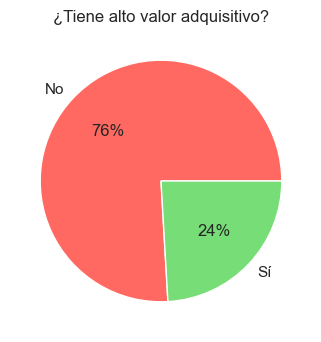

In [20]:
plt.figure(dpi=100)
df["tiene_alto_valor_adquisitivo"].apply(lambda x: 'Sí' if x==1 else 'No').value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=['#ff6961', '#77dd77']
)
plt.title('¿Tiene alto valor adquisitivo?')
plt.ylabel("")
plt.show()

Como podemos observar, cerca de las tres cuartas partes de las personas muestreadas tienen un bajo poder adquisitivo. 

Para continuar el análisis, vamos a ver cómo se relaciona (si es que lo hacen) cada columna del dataset con la variable objetivo

In [21]:
df.columns

Index(['anios_estudiados', 'barrio', 'categoria_de_trabajo', 'edad',
       'estado_marital', 'ganancia_perdida_declarada_bolsa_argentina',
       'genero', 'horas_trabajo_registradas', 'religion',
       'rol_familiar_registrado', 'tiene_alto_valor_adquisitivo', 'trabajo'],
      dtype='object')

### Edad

#### ¿Hay una relación entre la edad y el valor adquisitivo?
Para intentar responder esta pregunta, agruparemos a los individuos muestreados por su edad, y estudiaremos cuántas personas de cada grupo etario tienen alto o bajo poder adquisitivo.

Para facilitar el análisis y la visualización de los resultados, dichos grupos etarios serán bins de 10 años.

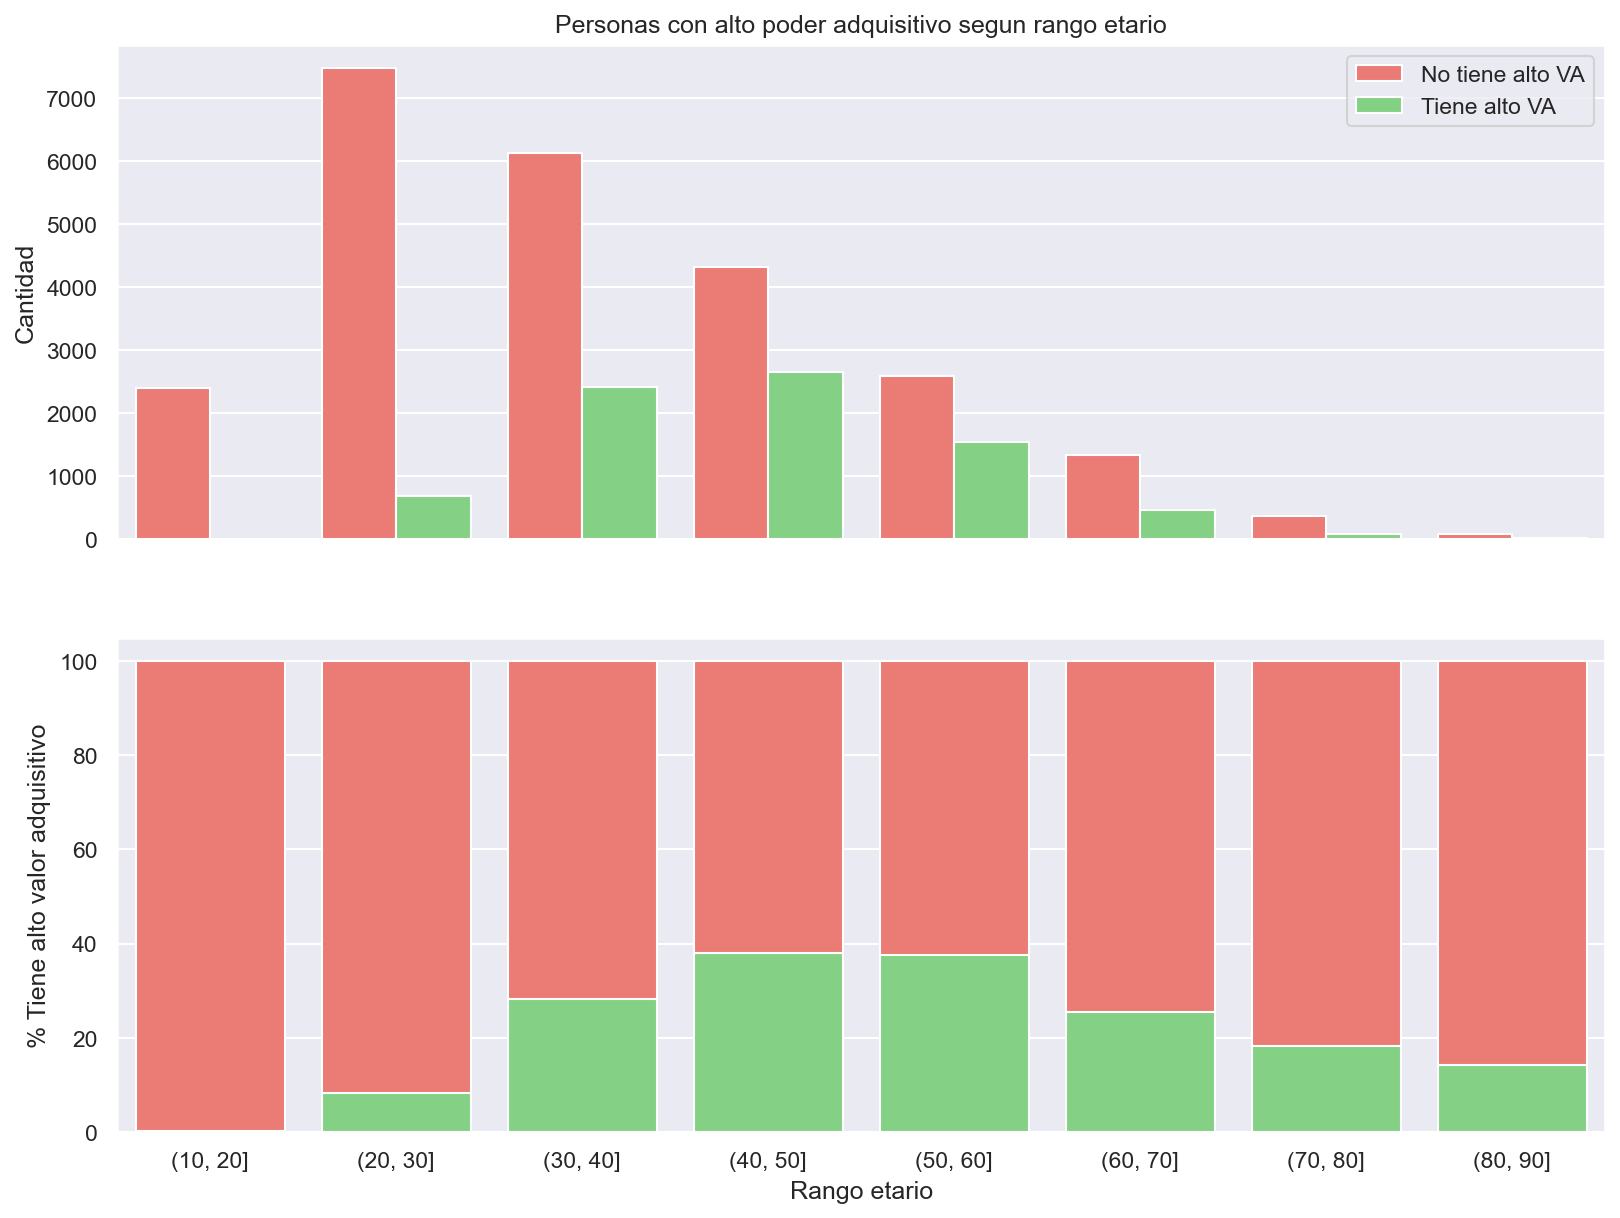

In [22]:
df_tmp = df[['edad', 'tiene_alto_valor_adquisitivo']].copy()
df_tmp['rango_etario'] = pd.cut(df_tmp.edad, range(10, int(df_tmp['edad'].max()) + 10, 10))

# Configuro el grafico, armo el countplot y setteo labels varios
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi=150, figsize=(6.4 * 2, 4.8 * 2))
sns.countplot(
    data = df_tmp,
    x = 'rango_etario',
    hue='tiene_alto_valor_adquisitivo',
    ax = ax1,
    palette = ['#ff6961', '#77dd77']
).set(xticklabels=[])

total = df_tmp.groupby('rango_etario')['tiene_alto_valor_adquisitivo'].count().reset_index()
df_tmp_1 = df_tmp[df_tmp['tiene_alto_valor_adquisitivo']==1].groupby('rango_etario')['tiene_alto_valor_adquisitivo'].count().reset_index()
df_tmp_1['tiene_alto_valor_adquisitivo'] = [i / j * 100 for i,j in zip(df_tmp_1['tiene_alto_valor_adquisitivo'], total['tiene_alto_valor_adquisitivo'])]
total['tiene_alto_valor_adquisitivo'] = [i / j * 100 for i,j in zip(total['tiene_alto_valor_adquisitivo'], total['tiene_alto_valor_adquisitivo'])]

bar1 = sns.barplot(x="rango_etario",  y="tiene_alto_valor_adquisitivo", data=total, color='#ff6961', ax=ax2)
bar2 = sns.barplot(x="rango_etario", y="tiene_alto_valor_adquisitivo", data=df_tmp_1, color='#77dd77', ax=ax2)

top_bar = mpatches.Patch(color='#ff6961')
bottom_bar = mpatches.Patch(color='#77dd77')

ax1.set_title('Personas con alto poder adquisitivo segun rango etario')
ax1.set_xlabel('')
ax1.set_ylabel('Cantidad')
ax1.legend(['No tiene alto VA', 'Tiene alto VA'], loc='upper right')

ax2.set_xlabel('Rango etario')
ax2.set_ylabel('% Tiene alto valor adquisitivo')


plt.show()

Como podemos ver, es más probable encontrar personas de alto poder adquisitivo entre aquellas que están entre los 30 y 70 años de edad. Mucho menos probable es que esto ocurra para personas de entre 20 y 30 años o más de 70 años, y no ocurrirá para personas menores de 20. Cabe notar que de 70 años en adelante son muy pocas las muestras tomadas.

### Acción en la bolsa

#### ¿Hay una relación entre accionar en la bolsa y el valor adquisitivo?
Para ello graficaremos la cantidad de gente que accionó en bolsa y la proporción de ellos que poseen un alto poder adquisitivo. Para segmentar a los individuos de la población que estamos estudiando, consideraremos cuatro grupos: por un lado, aquellos que no declararon operaciones en la bolsa argentina, que son aquellos cuyo valor es 0 en esta columna del dataset. Por otro lado, aquellos que informaron pérdidas, identificados por un número menor a 0 en esta columna. Y, entre quienes tienen un valor positivo, consideraremos "Mucha ganancia" a los valores mayores a 7000 y "Ganancia" al resto.

In [23]:
def designar_accion(x):
    if(x > 7000):
        return "Mucha ganancia\n(>7000)"
    elif(x > 0):
        return "Ganancia"
    elif(x == 0):
        return "Nada"
    else:
        return "Perdida"

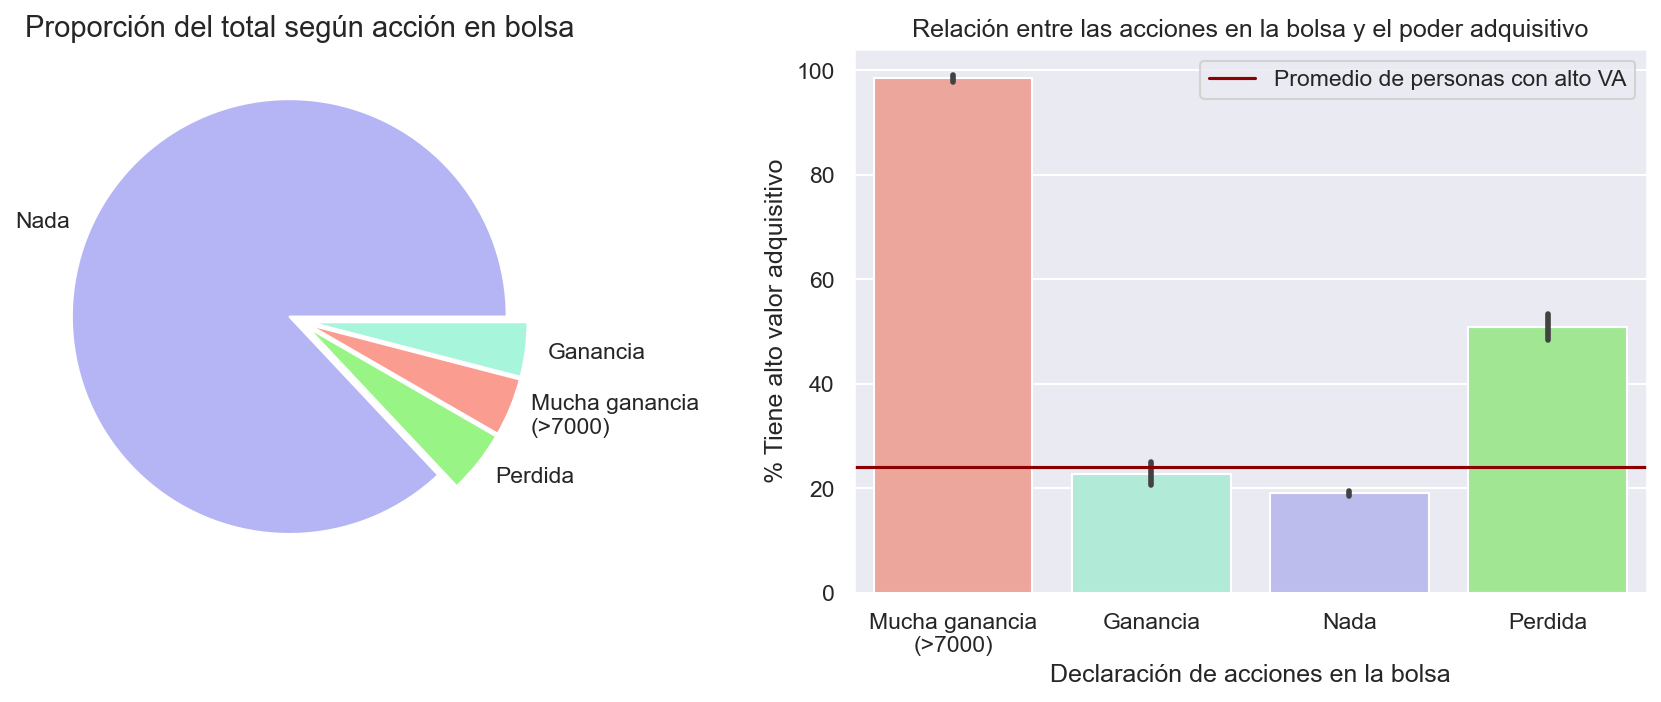

In [24]:
df_tmp = df[['ganancia_perdida_declarada_bolsa_argentina', 'tiene_alto_valor_adquisitivo']].copy()
df_tmp['bolsa'] = df['ganancia_perdida_declarada_bolsa_argentina'].apply(designar_accion)
del df_tmp['ganancia_perdida_declarada_bolsa_argentina']
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(7.5 * 2, 4.8))
color_nada = '#B5B5F5'
color_perdida = '#98F585' 
color_MGanancia = '#FA9C8F'
color_ganancia = '#A7F5DA'
labels = df_tmp['bolsa'].value_counts().keys()
ax1.pie(
    x=df_tmp['bolsa'].value_counts(),
    explode=[0.05]*4,
    labels=labels,
    pctdistance=0.5,
    colors = [color_nada, color_perdida, color_MGanancia, color_ganancia]
)
ax1.set_title("Proporción del total según acción en bolsa", fontsize=14);
sns.barplot(
    data=df_tmp,
    x='bolsa',
    y='tiene_alto_valor_adquisitivo',
    ax=ax2,
    estimator=lambda x: np.mean(x)*100.0,
    order = ['Mucha ganancia\n(>7000)', 'Ganancia', 'Nada', 'Perdida'],
    palette = [color_MGanancia, color_ganancia, color_nada, color_perdida]
)
ax2.set_ylabel("% Tiene alto valor adquisitivo")
ax2.set_xlabel("Declaración de acciones en la bolsa")
ax2.set_title('Relación entre las acciones en la bolsa y el poder adquisitivo')
prom = df['tiene_alto_valor_adquisitivo'].mean()*100.0
ax2.axhline(prom, color="darkred", label="Promedio de personas con alto VA")
ax2.legend()
plt.show()

### Barrio

#### ¿Hay una relación entre el barrio y el valor adquisitivo?
Veamos la distribución de las ciudades y cómo esta afecta al poder adquisitivo

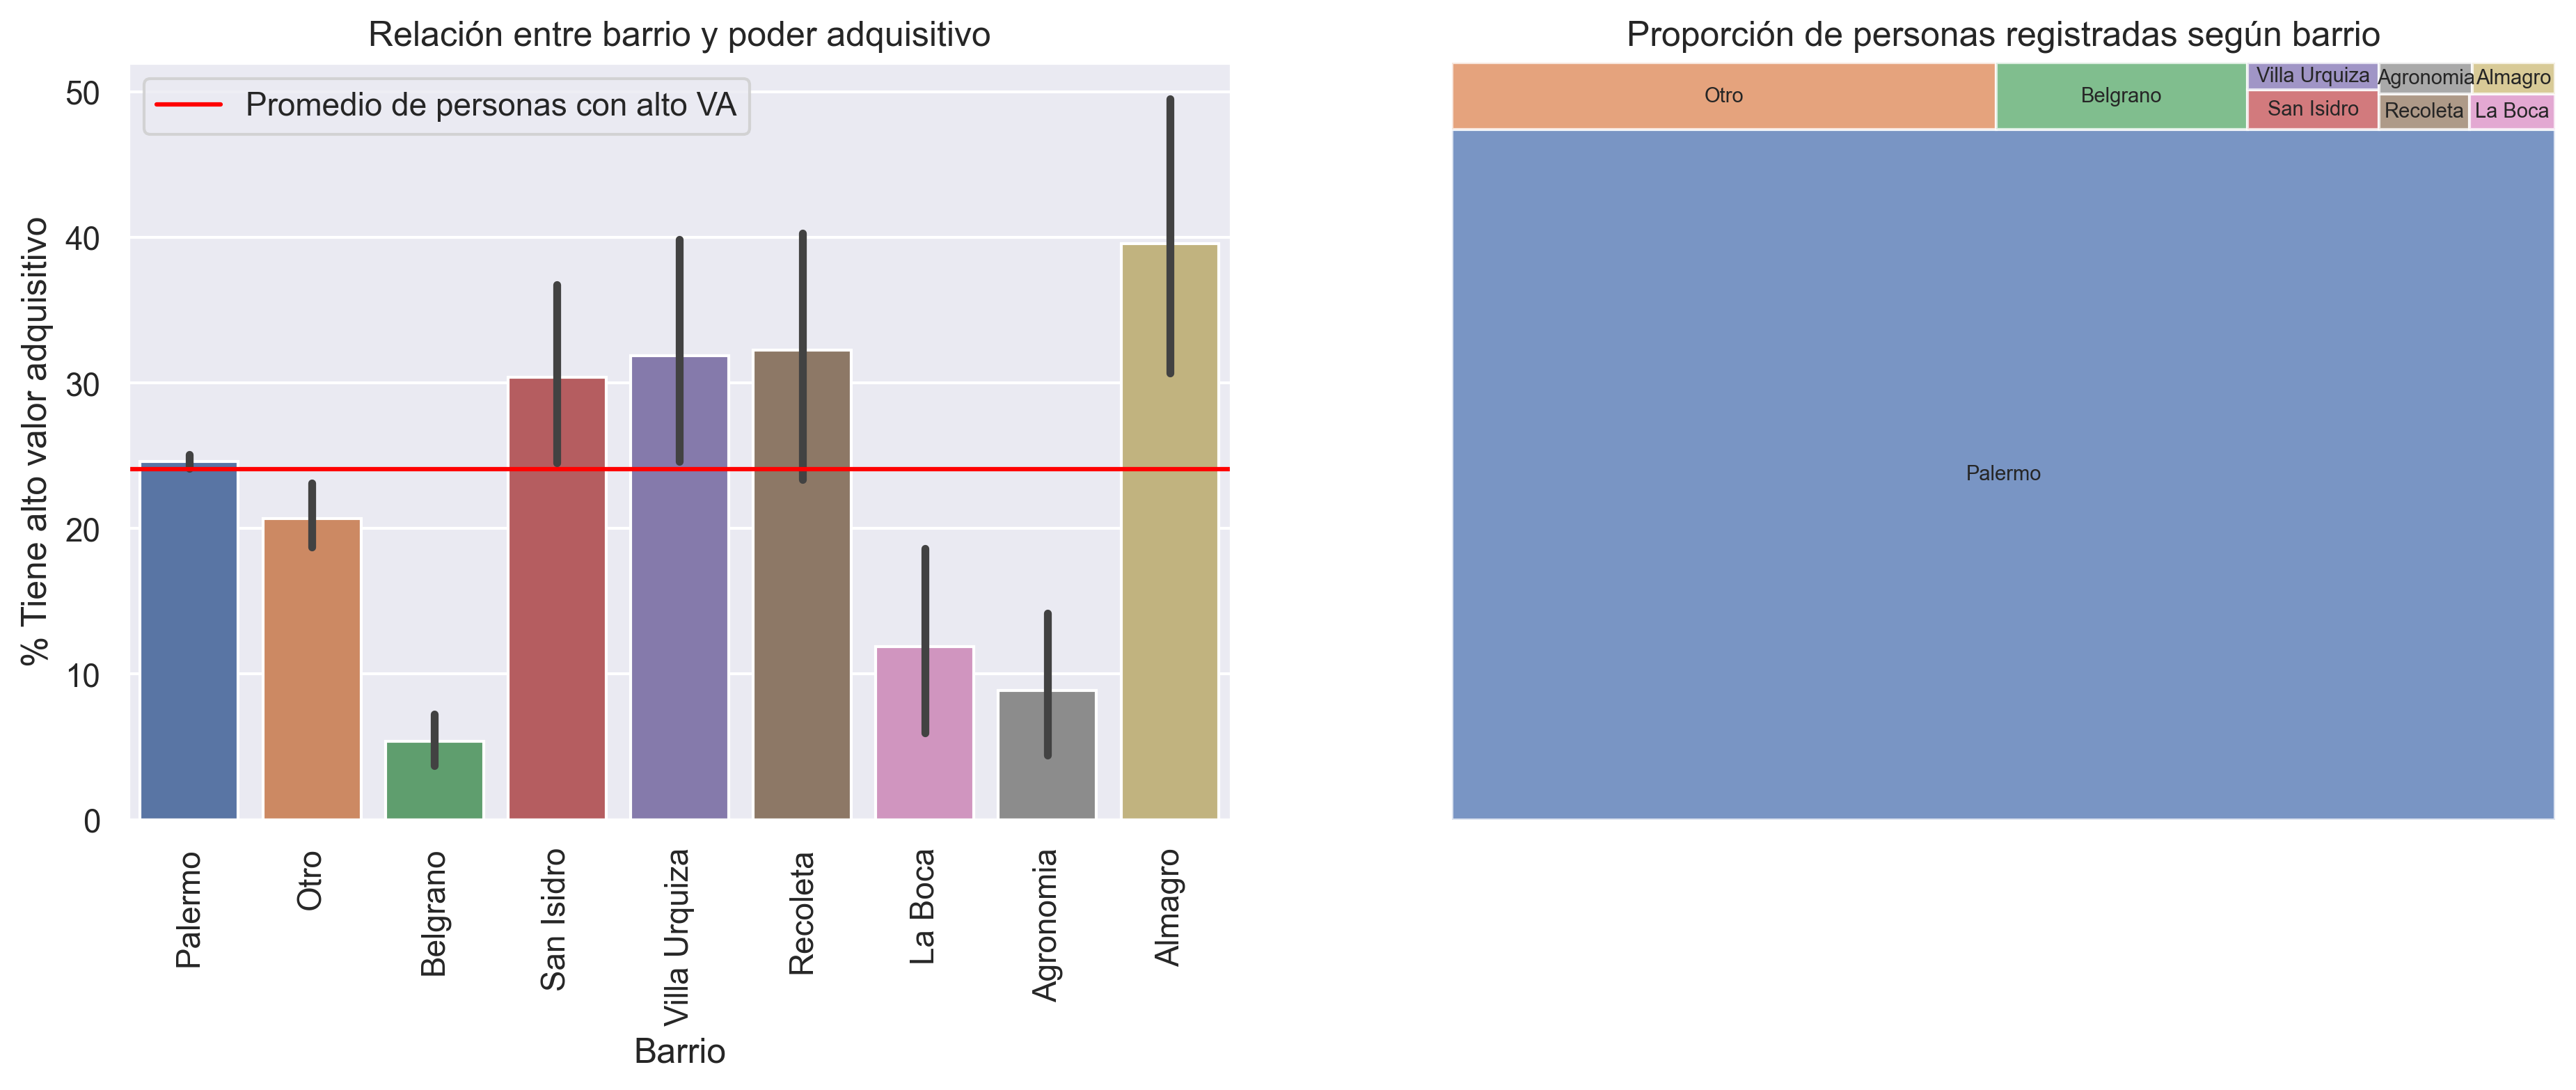

In [59]:
fig, (ax2, ax1) = plt.subplots(nrows=1, ncols=2, dpi=300, figsize=(7.5 * 2, 4.8))

cant_min = 100
tabla = df['barrio'].value_counts()
barrios_significativos = tabla[tabla > cant_min].reset_index()['index'].unique()
df_tmp = df[['barrio', 'tiene_alto_valor_adquisitivo']].copy()
df_tmp['barrio'] = df_tmp['barrio'].apply(lambda x: x if x in barrios_significativos else 'Otro')


paleta=sns.color_palette("deep")

barrios = df_tmp['barrio'].value_counts()
squarify.plot(barrios, label=barrios.keys(), alpha=0.75,color=paleta,  text_kwargs={'fontsize':7}, norm_x=1, norm_y=3, ax=ax1)
ax1.axis('off')

orden = df_tmp.groupby(['barrio'])['tiene_alto_valor_adquisitivo'].aggregate(lambda x : len(x)).reset_index().sort_values('tiene_alto_valor_adquisitivo', ascending = False)
sns.barplot(
    data=df_tmp,
    palette=paleta,
    x='barrio',
    y='tiene_alto_valor_adquisitivo',
    order=orden['barrio'],
    ax=ax2,
    estimator=lambda x: np.mean(x)*100.0
)

ax1.set_title("Proporción de personas registradas según barrio")
ax1.set_xlabel("Significancia mínima: 100 muestras")

ax2.set_ylabel("% Tiene alto valor adquisitivo")
ax2.set_xlabel("Barrio")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_title('Relación entre barrio y poder adquisitivo')
prom = df['tiene_alto_valor_adquisitivo'].mean()*100.0
ax2.axhline(prom, color="red", label="Promedio de personas con alto VA")
ax2.legend()

plt.show()

## Observaciones

## Baseline

## Conclusión